## Importamos librerias
Paso necesario para trabajar con herramientas de python que nos permiten hacer analisis, graficas, etc.

In [29]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
import geopandas as gpd
import contextily as cx

In [30]:
df = pd.read_csv("20211220_EVALUACION_DOCENTE_2020_20210707_PUBL.csv",sep=";") #Creamos dataframe con datos 
df.head(5) # Visualizamos las primeras 5 filas del dataframe para ver los datos

,AGNO_EVAL,RBD,DGV_RBD,NOM_RBD,COD_REG_RBD,COD_PRO_RBD,COD_COM_RBD,NOM_COM_RBD,COD_DEPROV_RBD,NOM_DEPROV_RBD,...,ESTADO_ESTAB,MRUN,DOC_GENERO,DOC_FEC_NAC,NIVEL,PF_PJE,PF_ESC,PF_Cat_Carrera,INSTR_PJE,INSTR_ESC
0,2020,3,5,ESC. PEDRO VICENTE GUTIERREZ TORRES,15,151,15101,ARICA,151,ARICA,...,1,2506691,1,197703,ECE,"2,79",C,B,"3,07",D
1,2020,3,5,ESC. PEDRO VICENTE GUTIERREZ TORRES,15,151,15101,ARICA,151,ARICA,...,1,15428050,2,197306,ECE,"2,92",C,B,"3,15",D
2,2020,4,3,LICEO OCTAVIO PALMA PEREZ,15,151,15101,ARICA,151,ARICA,...,1,11465866,2,196907,EM,"2,6",C,B,"2,66",C
3,2020,5,1,JOVINA NARANJO FERNANDEZ,15,151,15101,ARICA,151,ARICA,...,1,13354326,1,196109,EM,"3,08",D,A,"3,35",D
4,2020,9,4,ESCUELA REPUBLICA DE ISRAEL,15,151,15101,ARICA,151,ARICA,...,1,6054839,2,198905,EE,"1,34",I,E,"2,2",B


## Tarea 1: Limpieza y Preparación de Datos
1.Identificación de valores faltantes: Revisa la base de datos y verifica si hay valores faltantes en las variables clave, como PF_PJE (Puntaje Portafolio) o INSTR_PJE (Puntaje Final en base a resultados en instrumentos). Si encuentras valores faltantes, decide cómo manejarlos (eliminación, imputación, etc.).

2.Normalización de datos: Asegúrate de que todas las variables numéricas estén en el formato correcto (por ejemplo, fechas en formato AAAAMMDD). Si es necesario, convierte las variables categóricas a factores o códigos numéricos.

## Respuesta Tarea 1

In [31]:
df['PF_PJE'] = df['PF_PJE'].str.replace(',', '.').astype(float)
df['INSTR_PJE'] = pd.to_numeric(df['INSTR_PJE'].str.replace(',', '.').str.strip(),errors='coerce')
df = df[df['INSTR_PJE'] != -1]
df = df.dropna()

In [32]:
regiones_key = {
    1: 'Tarapacá',
    2: 'Antofagasta', 
    3: 'Atacama',
    4: 'Coquimbo',
    5: 'Valparaíso',
    6: "Libertador General Bernardo O'Hi",
    7: 'Maule',
    8: 'Bío-Bío',
    9: 'Araucanía',
    10: 'Los Lagos',
    11: 'Aysén del General Ibañez del Cam',
    12: 'Magallanes y Antártica Chilena',
    13: 'Santiago Metropolitan',
    14: 'Los Ríos',
    15: 'Arica y Parinacota',
    16: 'Ñuble'
}

df['NOM_REG'] = df['COD_REG_RBD'].map(regiones_key)

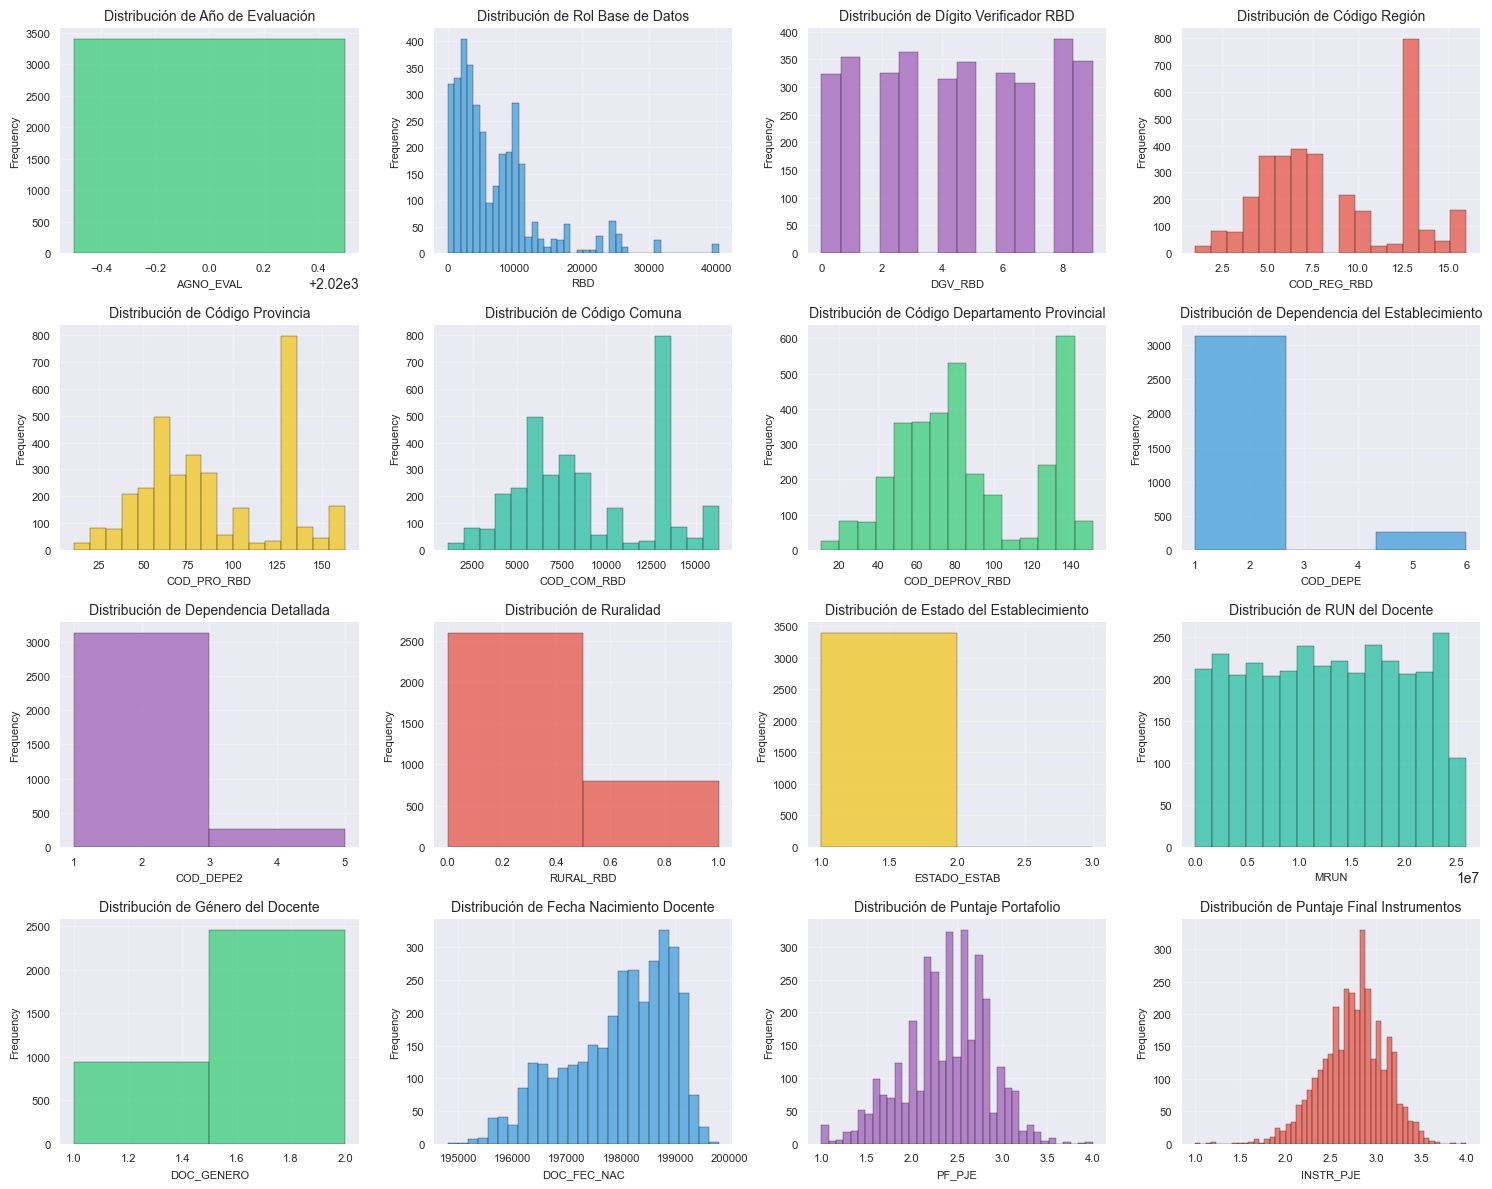

In [41]:
names = {
    'AGNO_EVAL': 'Año de Evaluación',
    'RBD': 'Rol Base de Datos',
    'DGV_RBD': 'Dígito Verificador RBD',
    'NOM_RBD': 'Nombre del Establecimiento',
    'COD_REG_RBD': 'Código Región',
    'COD_PRO_RBD': 'Código Provincia',
    'COD_COM_RBD': 'Código Comuna',
    'NOM_COM_RBD': 'Nombre Comuna',
    'COD_DEPROV_RBD': 'Código Departamento Provincial',
    'NOM_DEPROV_RBD': 'Nombre Departamento Provincial',
    'COD_DEPE': 'Dependencia del Establecimiento',
    'COD_DEPE2': 'Dependencia Detallada',
    'RURAL_RBD': 'Ruralidad',
    'ESTADO_ESTAB': 'Estado del Establecimiento',
    'MRUN': 'RUN del Docente',
    'DOC_GENERO': 'Género del Docente',
    'DOC_FEC_NAC': 'Fecha Nacimiento Docente',
    'NIVEL': 'Nivel de Enseñanza',
    'PF_PJE': 'Puntaje Portafolio',
    'PF_ESC': 'Nivel de Desempeño Portafolio',
    'PF_Cat_Carrera': 'Categoría Carrera Docente',
    'INSTR_PJE': 'Puntaje Final Instrumentos',
    'INSTR_ESC': 'Nivel Final Instrumentos'
}

plt.style.use('seaborn-v0_8')  # Changed from 'seaborn' to 'ggplot' which is a built-in style
# Create figure and subplots with better spacing
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 12))
# fig.suptitle('Distribution of Variables', fontsize=16, y=0.95)

# Flatten axes array for easier iteration
axes = axes.ravel()

# Numerical columns to plot
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Custom colors
colors = ['#2ecc71', '#3498db', '#9b59b6', '#e74c3c', '#f1c40f', '#1abc9c']

# Plot each numeric column with individual settings
for idx, col in enumerate(numeric_cols):
    if idx < len(axes):  # Ensure we don't exceed available subplots
        # Determine optimal number of bins based on data
        if df[col].nunique() < 10:
            bins = df[col].nunique()
        else:
            bins = 'auto'
            
        # Create histogram
        df[col].hist(ax=axes[idx], 
                    bins=bins,
                    color=colors[idx % len(colors)],
                    alpha=0.7,
                    edgecolor='black')
        
        # Customize each subplot
        title = names.get(col, col)
        axes[idx].set_title(f'Distribución de {title}', fontsize=10)
        axes[idx].set_xlabel(col, fontsize=8)
        axes[idx].set_ylabel('Frequency', fontsize=8)
        axes[idx].tick_params(labelsize=8)
        axes[idx].grid(True, alpha=0.3)

# Remove empty subplots if any
for idx in range(len(numeric_cols), len(axes)):
    fig.delaxes(axes[idx])

# Adjust layout
plt.tight_layout()
plt.show()

# Limpieza y Preparación de Datos de Evaluación Docente

De acuerdo a la información dada por el pdf, analizamos el tipo de dato de cada columna, identificando tres casos principales:

1. **Columna faltante**: En el archivo CSV no existe la columna 'NOM_REG_RBD_A' mencionada en el PDF.

2. **Discrepancia de tipo de dato**: La columna 'NIVEL' debería ser numérica según la documentación, pero está como texto. No se modificará ya que no afecta nuestro análisis.

3. **Columnas numéricas almacenadas como texto**: Las columnas 'PF_PJE' y 'INSTR_PJE' requirieron conversión.

Para la columna 'PF_PJE':
- Se reemplazó la coma por punto decimal usando `str.replace(',', '.')`
- Se convirtió al tipo float con `astype(float)`

Para la columna 'INSTR_PJE':
- Se reemplazó la coma por punto decimal con `str.replace(',', '.')`
- Se eliminaron espacios en blanco con `str.strip()`
- Se convirtió a tipo numérico con `pd.to_numeric(..., errors='coerce')` para manejar valores problemáticos como NaN

En la columna 'INSTR_PJE' se identificaron valores en {-1} ∪ (1,4). Los valores -1 corresponden a docentes de colegios particulares, que fueron excluidos del análisis mediante `df = df[df['INSTR_PJE'] != -1]`.

Finalmente, se eliminaron todas las filas con valores NaN usando `df.dropna()`.

## Tarea 2: Análisis Exploratorio de Datos (EDA)

1. Distribución de puntajes: Realiza un análisis de la distribución de los puntajes de los docentes en las variables PF_PJE y INSTR_PJE. Usa histogramas o gráficos de densidad para visualizar la distribución.
2. Comparación por género: Analiza si hay diferencias significativas en los puntajes de evaluación entre docentes de diferentes géneros (DOC_GENERO). Puedes usar pruebas estadísticas como la prueba t o ANOVA, dependiendo de la distribución de los datos.
3. Análisis por región: Agrupa los datos por región (COD_REG_RBD) y compara los puntajes promedio de los docentes en cada región. Visualiza los resultados usando un gráfico de barras o un mapa geográfico.

In [43]:
print(df[['PF_PJE','INSTR_PJE']].describe())

            PF_PJE    INSTR_PJE
count  3397.000000  3397.000000
mean      2.383868     2.751404
std       0.467872     0.350532
min       1.000000     1.000000
25%       2.100000     2.530000
50%       2.430000     2.770000
75%       2.710000     2.980000
max       4.000000     4.000000


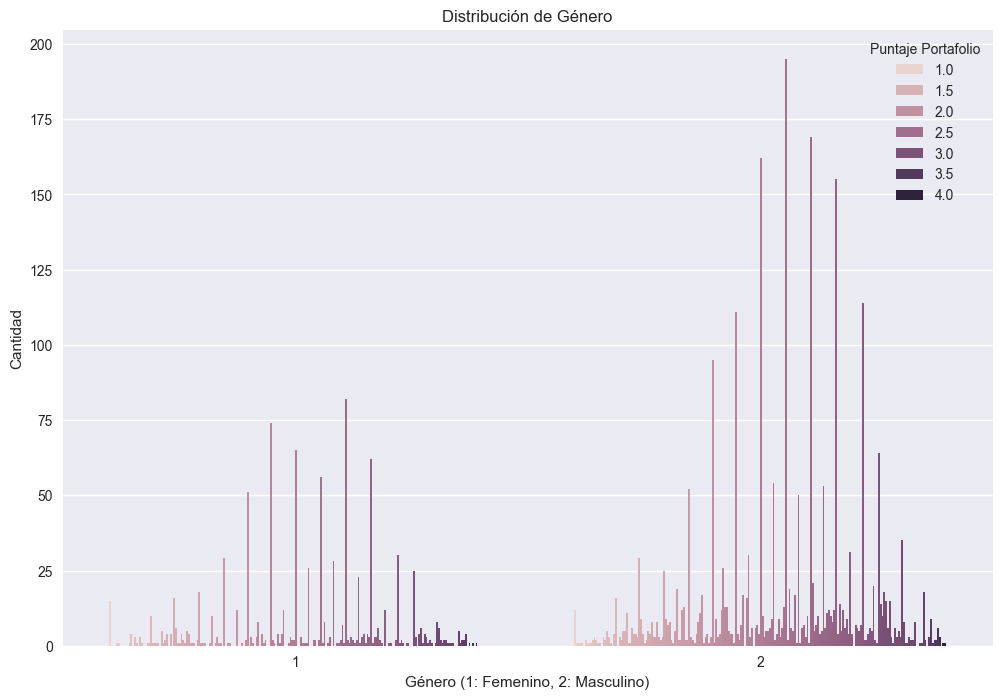

In [36]:
plt.figure(figsize=(12,8))
sns.countplot(data = df, x = 'DOC_GENERO', hue='PF_PJE')
plt.title('Distribución de Género')
plt.xlabel('Género (1: Femenino, 2: Masculino)')
plt.ylabel('Cantidad')
plt.legend(title='Puntaje Portafolio')
plt.show()

In [37]:
df_genero_1 = df[df['DOC_GENERO'] == 1]['PF_PJE']
df_genero_2 = df[df['DOC_GENERO'] == 2]['PF_PJE']

t_statistic,p_value = ttest_ind(df_genero_1,df_genero_2)

print(f"Estadístico t: {t_statistic}")
print(f"Valor p: {p_value}")

if p_value < 0.05:
    print("Rechazamos la hipótesis nula: hay una diferencia significativa entre los grupos.")
else:
    print("No rechazamos la hipótesis nula: no hay una diferencia significativa entre los grupos.")

del df_genero_1, df_genero_2 

Estadístico t: -3.9431250131364703
Valor p: 8.205013539834506e-05
Rechazamos la hipótesis nula: hay una diferencia significativa entre los grupos.


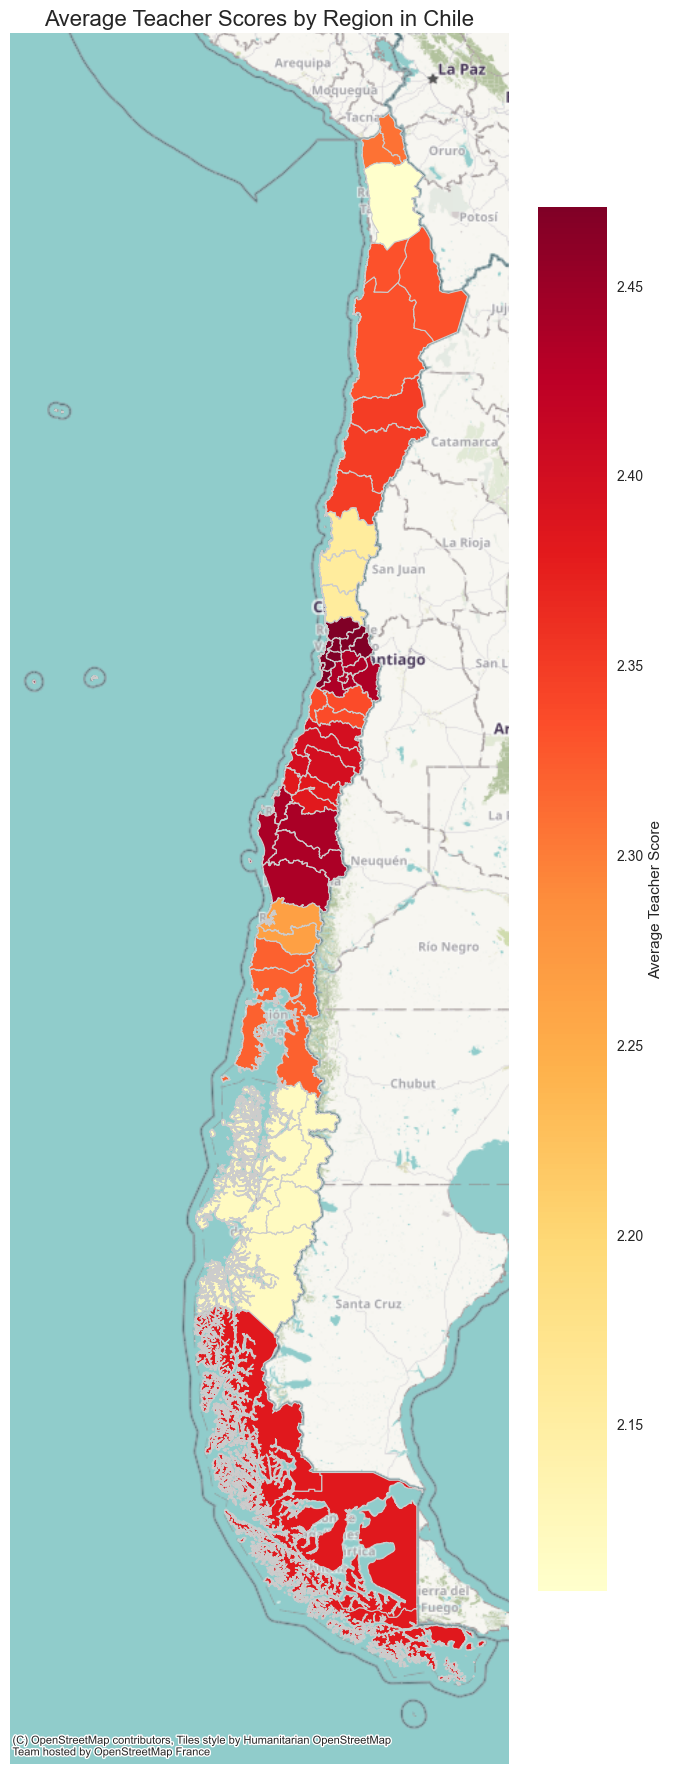

In [42]:
# Load the shapefile of Chilean communes
# You may need to download this file or use a different path
chile_region = gpd.read_file('Mapa_chile/gadm41_CHL_2.shp')

# Calculate average teacher score by commune
region_scores = df.groupby('NOM_REG')['PF_PJE'].mean().reset_index()

# Merge geographical data with score data
chile_map_reg = chile_region.merge(region_scores, left_on='NAME_1', right_on='NOM_REG', how='left')
del chile_region, region_scores

chile_map_reg.drop(47, inplace = True)
# Create the map
df_aux_1 = chile_map_reg.to_crs(epsg=3857)
fig, ax = plt.subplots(1, 1, figsize=(15, 18))
ax = df_aux_1.plot(column='PF_PJE', kind='geo', cmap='YlOrRd', linewidth=0.8, edgecolor='.8', ax=ax, legend=True, missing_kwds={'color': 'lightgrey'}, 
               legend_kwds={'label': 'Average Teacher Score', 'orientation': 'vertical', 'shrink': 0.8, 'pad': 0.02})

# ax = df_aux.plot(column='PF_PJE', kind = 'geo', cmap='YlOrRd', linewidth=0.8, edgecolor='.8', ax=ax, legend=True, missing_kwds={'color': 'lightgrey'}, 
            #    legend_kwds={'label': 'Average Teacher Score', 'orientation': 'horizontal'})

# Remove axis
ax.axis('off')

# Add a title
plt.title('Average Teacher Scores by Region in Chile', fontsize=16)
# Add background map
cx.add_basemap(ax)
plt.tight_layout()
plt.show()

## Tarea 3: Análisis de Correlación
1. Correlación entre variables: Calcula la correlación entre las variables PF_PJE y INSTR_PJE. ¿Existe una relación significativa entre el puntaje del portafolio y el puntaje final de los instrumentos? Usa un gráfico de dispersión para visualizar esta relación.
2. Correlación por nivel educativo: Analiza si el nivel educativo (NIVEL) tiene algún impacto en los puntajes de evaluación. ¿Los docentes de ciertos niveles tienden a obtener puntajes más altos o más bajos?

<Figure size 1200x800 with 0 Axes>

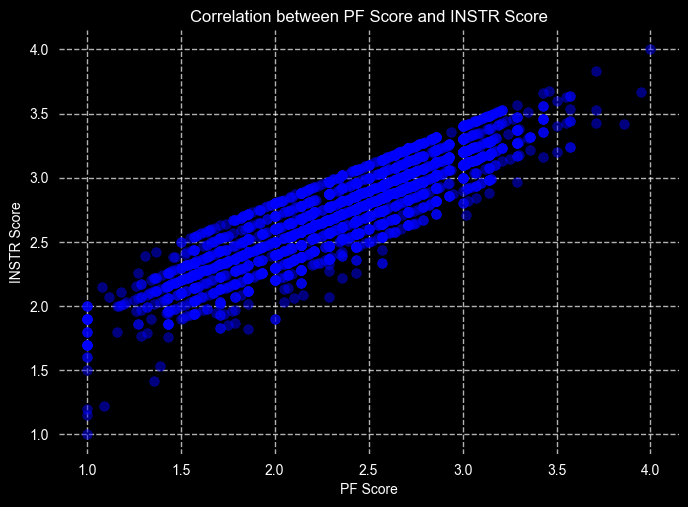

In [38]:
plt.style.use('dark_background')
plt.figure(figsize=(12, 8))
df.plot(kind='scatter', 
        x='PF_PJE', 
        y='INSTR_PJE',
        color='blue',
        alpha=0.5,
        s=50)
plt.title('Correlation between PF Score and INSTR Score', fontsize=12)
plt.xlabel('PF Score', fontsize=10)
plt.ylabel('INSTR Score', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


## Tarea 4: Visualización de Datos
1. Gráficos de tendencia temporal: Crea un gráfico de línea que muestre la evolución del número de observaciones (Número de observaciones) a lo largo de los años (desde 2012 hasta 2022). ¿Hay algún patrón o tendencia que llame
la atención?
2. Mapa de calor por región: Usa un mapa de calor para visualizar los puntajes promedio de los docentes en cada región. Esto te permitirá identificar regiones con puntajes más altos o más bajos.

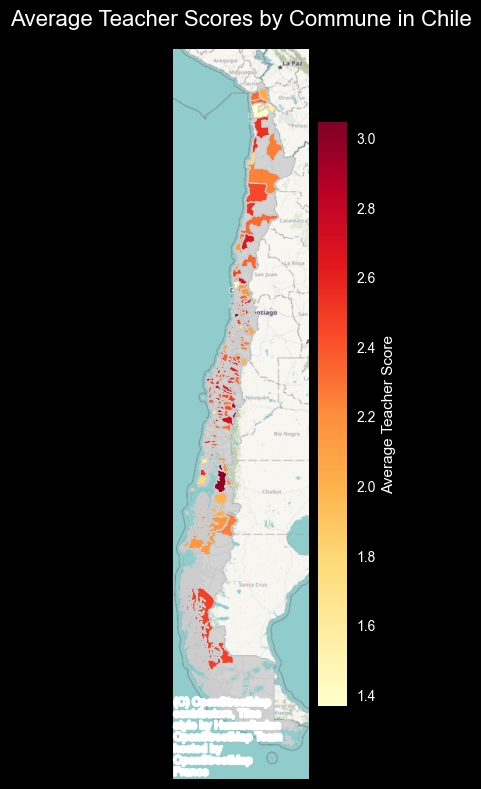

In [40]:
# Load the shapefile of Chilean communes
# You may need to download this file or use a different path
chile_communes = gpd.read_file('Mapa_chile/gadm41_CHL_3.shp')

# Calculate average teacher score by commune
commune_scores = df.groupby('NOM_COM_RBD')['PF_PJE'].mean().reset_index()
commune_scores['NOM_COM_RBD'] = commune_scores['NOM_COM_RBD'].str.capitalize()

# Merge geographical data with score data
chile_map = chile_communes.merge(commune_scores, left_on='NAME_3', right_on='NOM_COM_RBD', how='left')
del chile_communes, commune_scores

#drop the islands Juan fernandez (307) and isla de pascua (340)

chile_map.drop([307, 340], inplace = True)
# Create the map
df_aux = chile_map.to_crs(epsg=3857)
fig, ax = plt.subplots(1, 1, figsize=(5, 8))
ax = df_aux.plot(column='PF_PJE', kind='geo', cmap='YlOrRd', linewidth=0.8, edgecolor='.8', ax=ax, legend=True, missing_kwds={'color': 'lightgrey'}, 
               legend_kwds={'label': 'Average Teacher Score', 'orientation': 'vertical', 'shrink': 0.8, 'pad': 0.02})

# ax = df_aux.plot(column='PF_PJE', kind = 'geo', cmap='YlOrRd', linewidth=0.8, edgecolor='.8', ax=ax, legend=True, missing_kwds={'color': 'lightgrey'}, 
            #    legend_kwds={'label': 'Average Teacher Score', 'orientation': 'horizontal'})

# Remove axis
ax.axis('off')

# Add a title
plt.title('Average Teacher Scores by Commune in Chile', fontsize=16)
# Add background map
cx.add_basemap(ax)
plt.tight_layout()
plt.show()
